In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
import warnings            
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [4]:
# Load the uploaded CSV file
file_path = "Tweets.csv"
df = pd.read_csv(file_path)

In [5]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [7]:
df.shape

(14640, 15)

In [8]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [9]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [10]:
# Clean and preprocess tweets
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r"[^\w\s]", '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.strip()

In [11]:
df['clean_text'] = df['text'].apply(preprocess_text)

In [12]:
df.duplicated().sum()

36

In [13]:
df.drop_duplicates(inplace=True)

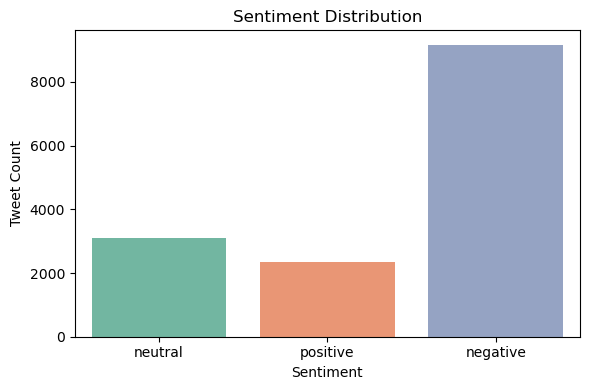

In [14]:
# EDA: Sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='airline_sentiment', palette='Set2')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.tight_layout()
plt.show()

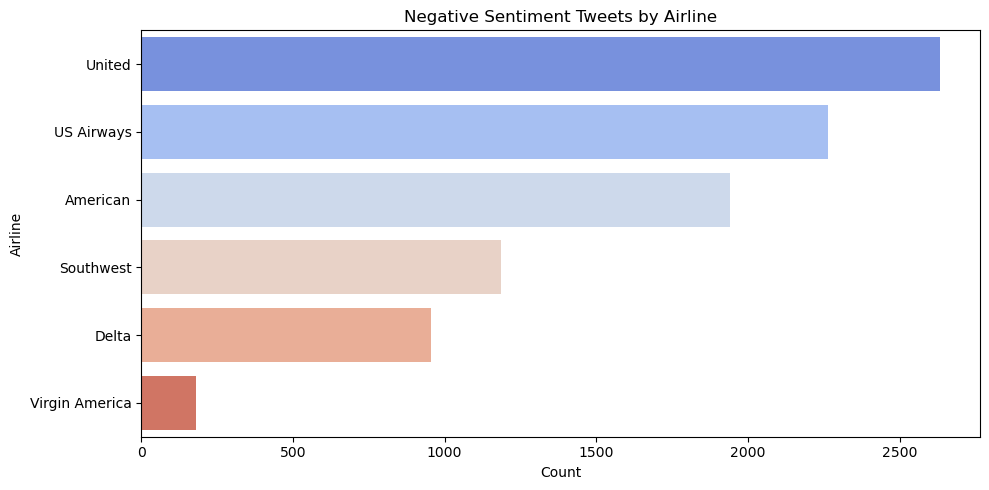

In [15]:
# EDA: Most frequent negative reasons
neg_df = df[df['airline_sentiment'] == 'negative']
plt.figure(figsize=(10, 5))
sns.countplot(y=neg_df['airline'], order=neg_df['airline'].value_counts().index, palette='coolwarm')
plt.title("Negative Sentiment Tweets by Airline")
plt.xlabel("Count")
plt.ylabel("Airline")
plt.tight_layout()
plt.show()

In [16]:
def show_wordcloud(data, title):
    text = " ".join(data)
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.show()

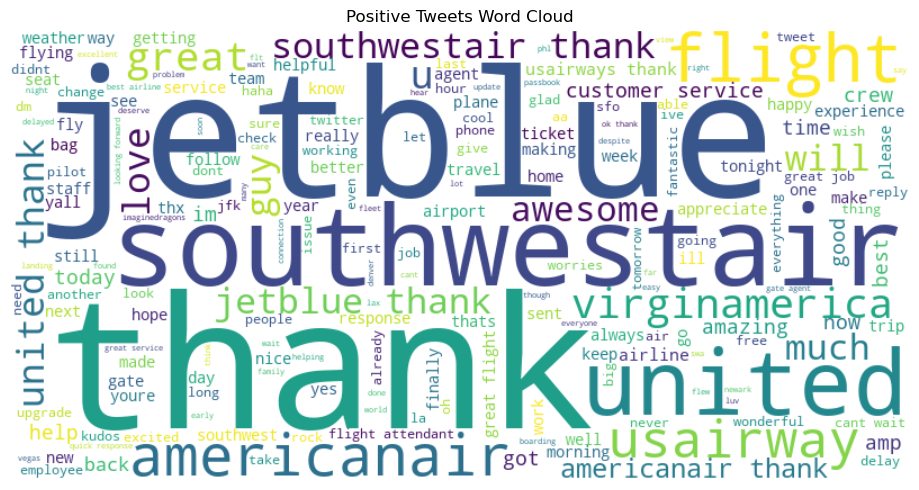

In [17]:
show_wordcloud(df[df['airline_sentiment']=='positive']['clean_text'], "Positive Tweets Word Cloud")

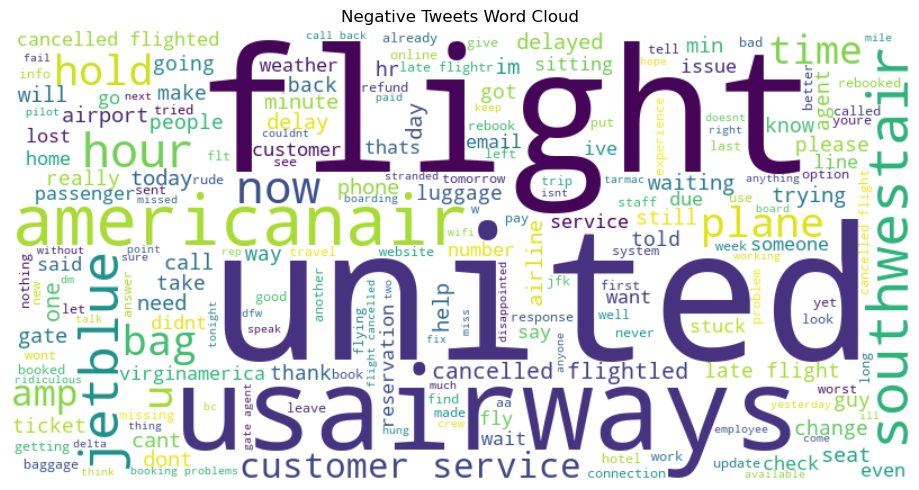

In [18]:
show_wordcloud(df[df['airline_sentiment']=='negative']['clean_text'], "Negative Tweets Word Cloud")

In [19]:
# Split dataset
X = df['clean_text']
y = df['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# TF-IDF Vectorizer for ML models
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [21]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
lr_preds = lr_model.predict(X_test_tfidf)

In [22]:
lr_accuracy = accuracy_score(y_test, lr_preds)
print(f"Accuracy: {lr_accuracy:.4f}")

Accuracy: 0.8076


In [23]:
lr_conf_matrix = confusion_matrix(y_test, lr_preds)
print(lr_conf_matrix)

[[1754  103   23]
 [ 223  319   40]
 [ 108   65  286]]


In [24]:
lr_class_report = classification_report(y_test, lr_preds)
print(lr_class_report)

              precision    recall  f1-score   support

    negative       0.84      0.93      0.88      1880
     neutral       0.66      0.55      0.60       582
    positive       0.82      0.62      0.71       459

    accuracy                           0.81      2921
   macro avg       0.77      0.70      0.73      2921
weighted avg       0.80      0.81      0.80      2921



In [25]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [26]:
nb_preds = nb_model.predict(X_test_tfidf)

In [27]:
nb_accuracy = accuracy_score(y_test, nb_preds)
print(f"Accuracy: {nb_accuracy:.4f}")

Accuracy: 0.7285


In [28]:
nb_conf_matrix = confusion_matrix(y_test, nb_preds)
print(nb_conf_matrix)

[[1864   13    3]
 [ 440  128   14]
 [ 291   32  136]]


In [29]:
nb_class_report = classification_report(y_test, nb_preds)
print(nb_class_report)

              precision    recall  f1-score   support

    negative       0.72      0.99      0.83      1880
     neutral       0.74      0.22      0.34       582
    positive       0.89      0.30      0.44       459

    accuracy                           0.73      2921
   macro avg       0.78      0.50      0.54      2921
weighted avg       0.75      0.73      0.67      2921



In [30]:
# Encode string labels into numeric
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [31]:
# XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_tfidf, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [32]:
xgb_preds = xgb_model.predict(X_test_tfidf)

In [33]:
# Decode predictions back to original labels
xgb_preds = le.inverse_transform(xgb_preds)

In [34]:
xgb_accuracy = accuracy_score(y_test, xgb_preds)
print(f"Accuracy: {xgb_accuracy:.4f}")

Accuracy: 0.7980


In [35]:
xgb_conf_matrix = confusion_matrix(y_test, xgb_preds)
print(xgb_conf_matrix)

[[1722  118   40]
 [ 217  320   45]
 [  93   77  289]]


In [36]:
xgb_class_report = classification_report(y_test, xgb_preds)
print(xgb_class_report)

              precision    recall  f1-score   support

    negative       0.85      0.92      0.88      1880
     neutral       0.62      0.55      0.58       582
    positive       0.77      0.63      0.69       459

    accuracy                           0.80      2921
   macro avg       0.75      0.70      0.72      2921
weighted avg       0.79      0.80      0.79      2921



In [37]:
# LSTM
# Parameters
max_words = 5000
max_len = 50
embedding_dim = 64
batch_size = 64
epochs = 5

In [38]:
y_encoded = le.fit_transform(y)

In [39]:
# Split dataset
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(df['clean_text'], y_encoded, test_size=0.2, random_state=42)

In [40]:
# Tokenization
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_seq)

In [41]:
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train_seq), maxlen=max_len, padding='post')
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test_seq), maxlen=max_len, padding='post')

In [42]:
# LSTM Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 sentiment classes
])

In [43]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Train model
model.fit(X_train_pad, y_train_seq, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6202 - loss: 0.9296 - val_accuracy: 0.6886 - val_loss: 0.7041
Epoch 2/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7105 - loss: 0.6719 - val_accuracy: 0.7596 - val_loss: 0.5920
Epoch 3/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8042 - loss: 0.4952 - val_accuracy: 0.7682 - val_loss: 0.5891
Epoch 4/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8578 - loss: 0.4020 - val_accuracy: 0.7913 - val_loss: 0.6016
Epoch 5/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8872 - loss: 0.3387 - val_accuracy: 0.7742 - val_loss: 0.6498


In [46]:
# Predict
y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [47]:
lstm_accuracy = accuracy_score(y_test_seq, y_pred)
print(f"Accuracy: {lstm_accuracy:.4f}")

Accuracy: 0.7795


In [48]:
print(confusion_matrix(y_test_seq, y_pred))

[[1594  181  105]
 [ 143  321  118]
 [  55   42  362]]


In [49]:
print(classification_report(y_test_seq, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

    negative       0.89      0.85      0.87      1880
     neutral       0.59      0.55      0.57       582
    positive       0.62      0.79      0.69       459

    accuracy                           0.78      2921
   macro avg       0.70      0.73      0.71      2921
weighted avg       0.79      0.78      0.78      2921



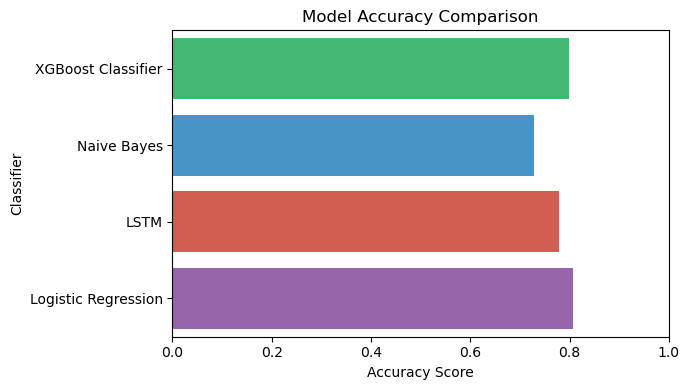

In [50]:
data = [ ['XGBoost Classifier', xgb_accuracy],
       ['Naive Bayes', nb_accuracy],['LSTM', lstm_accuracy],
       ['Logistic Regression', lr_accuracy]]
df = pd.DataFrame(data, columns=['Classifiers Name', 'Accuracy'])
# Set up the plot
plt.figure(figsize=(7, 4))
sns.barplot(
    x='Accuracy',
    y='Classifiers Name',
    data=df,
    palette=['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']  # Green, Blue, Red, Purple
)

plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy Score')
plt.ylabel('Classifier')
plt.xlim(0, 1) 
plt.tight_layout()
plt.show()